### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.RetFound import get_retfound
from src.FocalLoss import FocalLoss

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGES = os.path.join(DATASET, 'images/')
DOWNLOAD = False
SHAPE = (224, 224)
LABEL = 'DR_ICDR'
IMAGE_COL = 'image_id'
TEST_SIZE = 0.3
UNDERSAMPLE = False

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'retfound'
MODE = 'fine_tune'
backbone_mode='fine_tune'

HIDDEN = None
num_classes = 3

BATCH_SIZE = 8
NUM_WORKERS = 2

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 15
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))


Train data shape: (1208, 35)
Test data shape: (4880, 35)


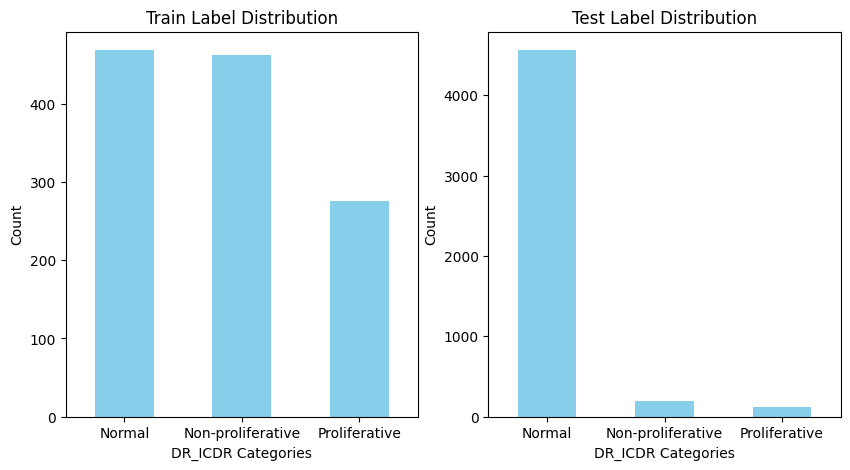

Getting validation set...
Train data shape: (4148, 35)
Test data shape: (732, 35)


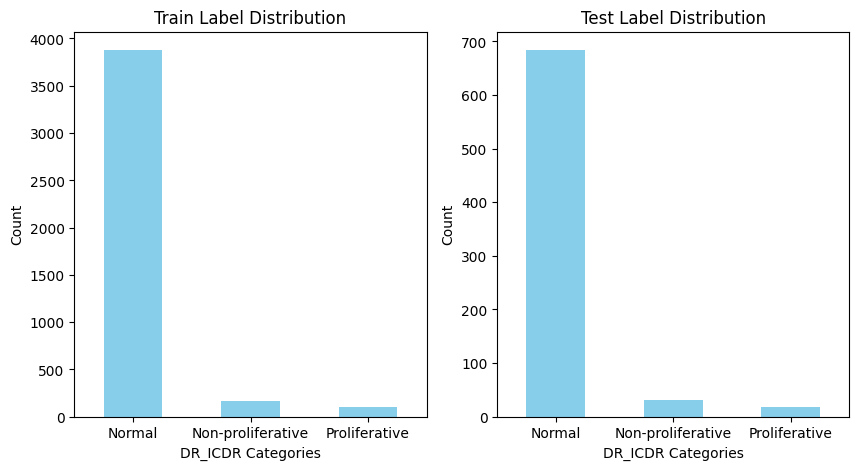

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=True, undersample_ratio=1.7)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.15)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


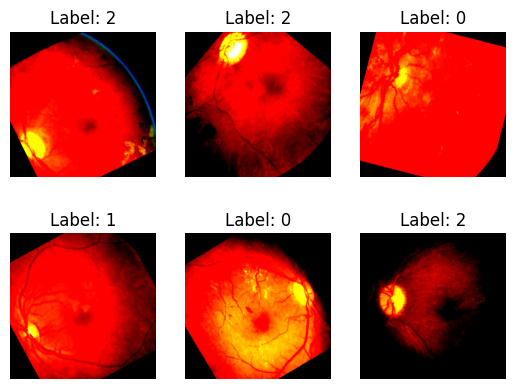

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create a DataLoader to generate embeddings
model = get_retfound(weights='/home/opc/FoundationalRetina/Weights/RETFound_cfp_weights.pth', num_classes=3)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [463 469 276]


100%|██████████| 151/151 [01:30<00:00,  1.68it/s]


Epoch 1, Training Loss: 0.2983553655297551


100%|██████████| 92/92 [00:27<00:00,  3.36it/s]


Epoch 1, Validation Loss: 0.26652247021379677, F1 Score: 0.3691521109151084


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 2, Training Loss: 0.23645570494283905


100%|██████████| 92/92 [00:26<00:00,  3.53it/s]


Epoch 2, Validation Loss: 0.23975870547735173, F1 Score: 0.3972353663235391


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 3, Training Loss: 0.1904429824443053


100%|██████████| 92/92 [00:26<00:00,  3.53it/s]


Epoch 3, Validation Loss: 0.1372224305877867, F1 Score: 0.5544626593806922


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 4, Training Loss: 0.16357826298435793


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Epoch 4, Validation Loss: 0.1318711099093375, F1 Score: 0.5670717685611749


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 5, Training Loss: 0.15231933188162103


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Epoch 5, Validation Loss: 0.13089634312073822, F1 Score: 0.5399473633571977


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 6, Training Loss: 0.13856033153141176


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Epoch 6, Validation Loss: 0.18049487876503365, F1 Score: 0.5104493194620966


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 7, Training Loss: 0.1354531768635409


100%|██████████| 92/92 [00:26<00:00,  3.45it/s]


Epoch 7, Validation Loss: 0.09100851639295401, F1 Score: 0.5777968817944712


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 8, Training Loss: 0.12534774501888168


100%|██████████| 92/92 [00:25<00:00,  3.60it/s]


Epoch 8, Validation Loss: 0.07869049071577257, F1 Score: 0.6340119429160292


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 9, Training Loss: 0.1164606742511522


100%|██████████| 92/92 [00:25<00:00,  3.59it/s]


Epoch 9, Validation Loss: 0.12481474637499322, F1 Score: 0.5818723017910356


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 10, Training Loss: 0.11155930482196492


100%|██████████| 92/92 [00:25<00:00,  3.65it/s]


Epoch 10, Validation Loss: 0.14652590627741555, F1 Score: 0.5491363780516113


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 11, Training Loss: 0.11188028256920789


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Epoch 11, Validation Loss: 0.10960058744429894, F1 Score: 0.5983550630093457


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 12, Training Loss: 0.10287388770637527


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Epoch 12, Validation Loss: 0.08089000082817739, F1 Score: 0.6477655677655677


100%|██████████| 151/151 [01:24<00:00,  1.78it/s]


Epoch 13, Training Loss: 0.09539479207222824


100%|██████████| 92/92 [00:26<00:00,  3.47it/s]


Epoch 13, Validation Loss: 0.08006260400314046, F1 Score: 0.6507489025469133


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 14, Training Loss: 0.09328270226174237


100%|██████████| 92/92 [00:26<00:00,  3.52it/s]


Epoch 14, Validation Loss: 0.10398036016799185, F1 Score: 0.5933887815315096


100%|██████████| 151/151 [01:24<00:00,  1.79it/s]


Epoch 15, Training Loss: 0.09596286286038673


100%|██████████| 92/92 [00:26<00:00,  3.50it/s]


Epoch 15, Validation Loss: 0.06039365070224132, F1 Score: 0.6814824515453117


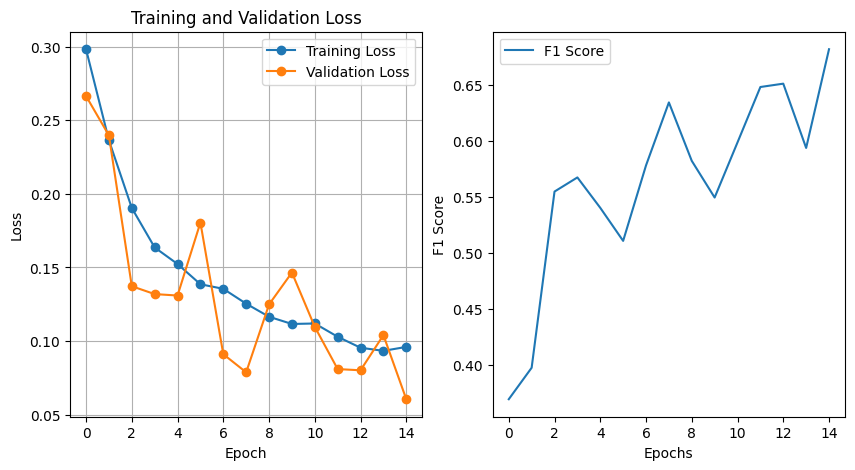

Training finished.


In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=False, device=device)

### Test

  2%|▏         | 9/519 [00:03<02:49,  3.00it/s]

100%|██████████| 519/519 [02:27<00:00,  3.52it/s]


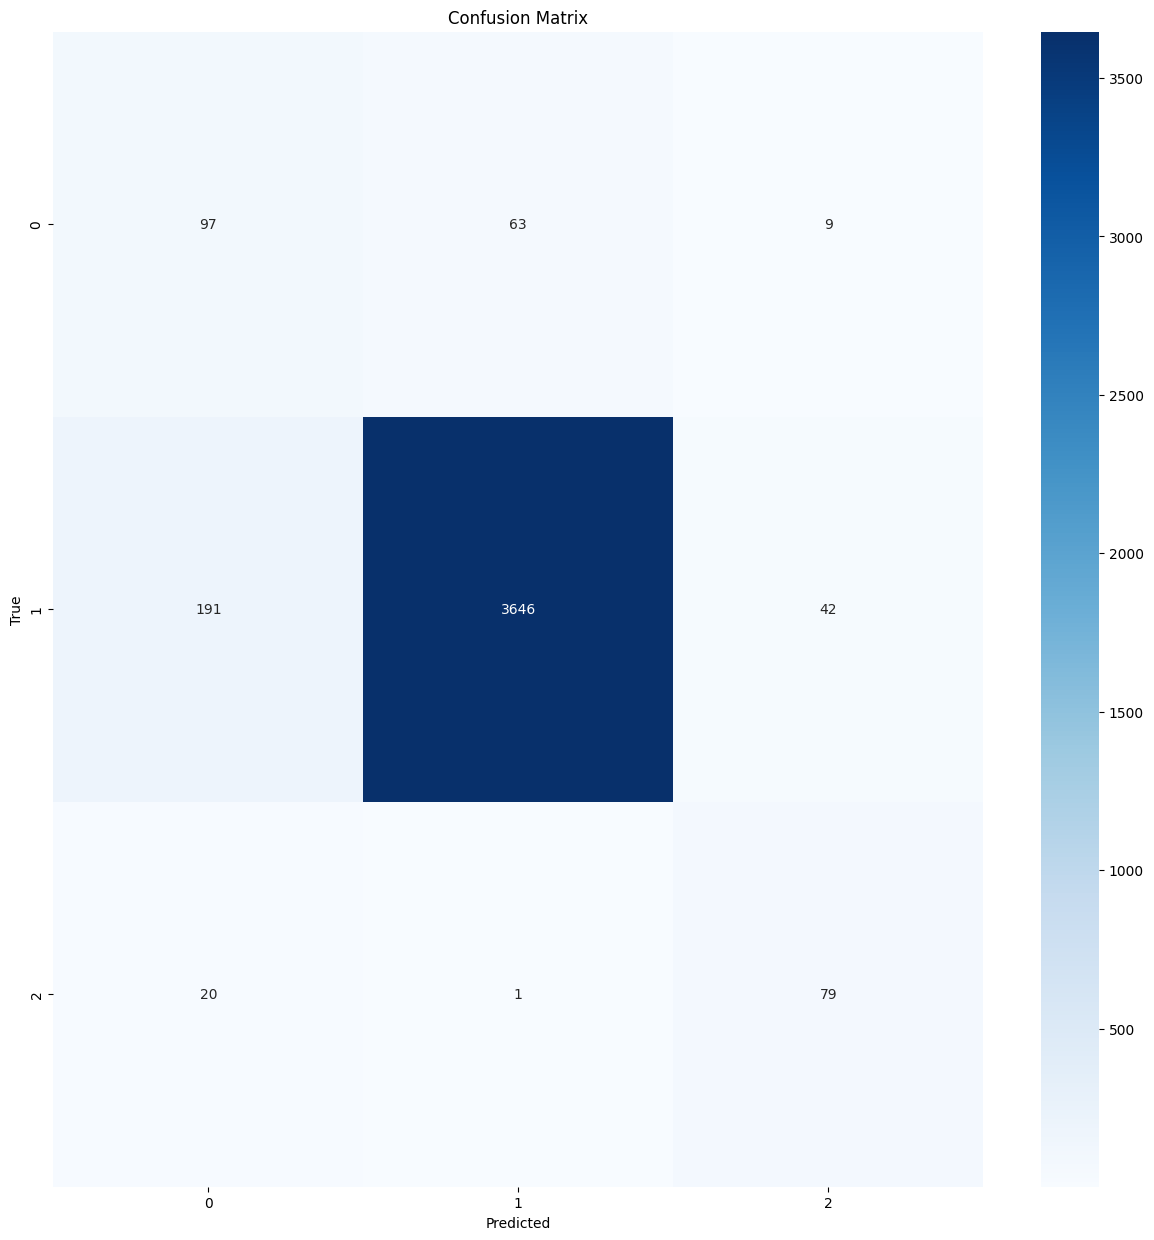

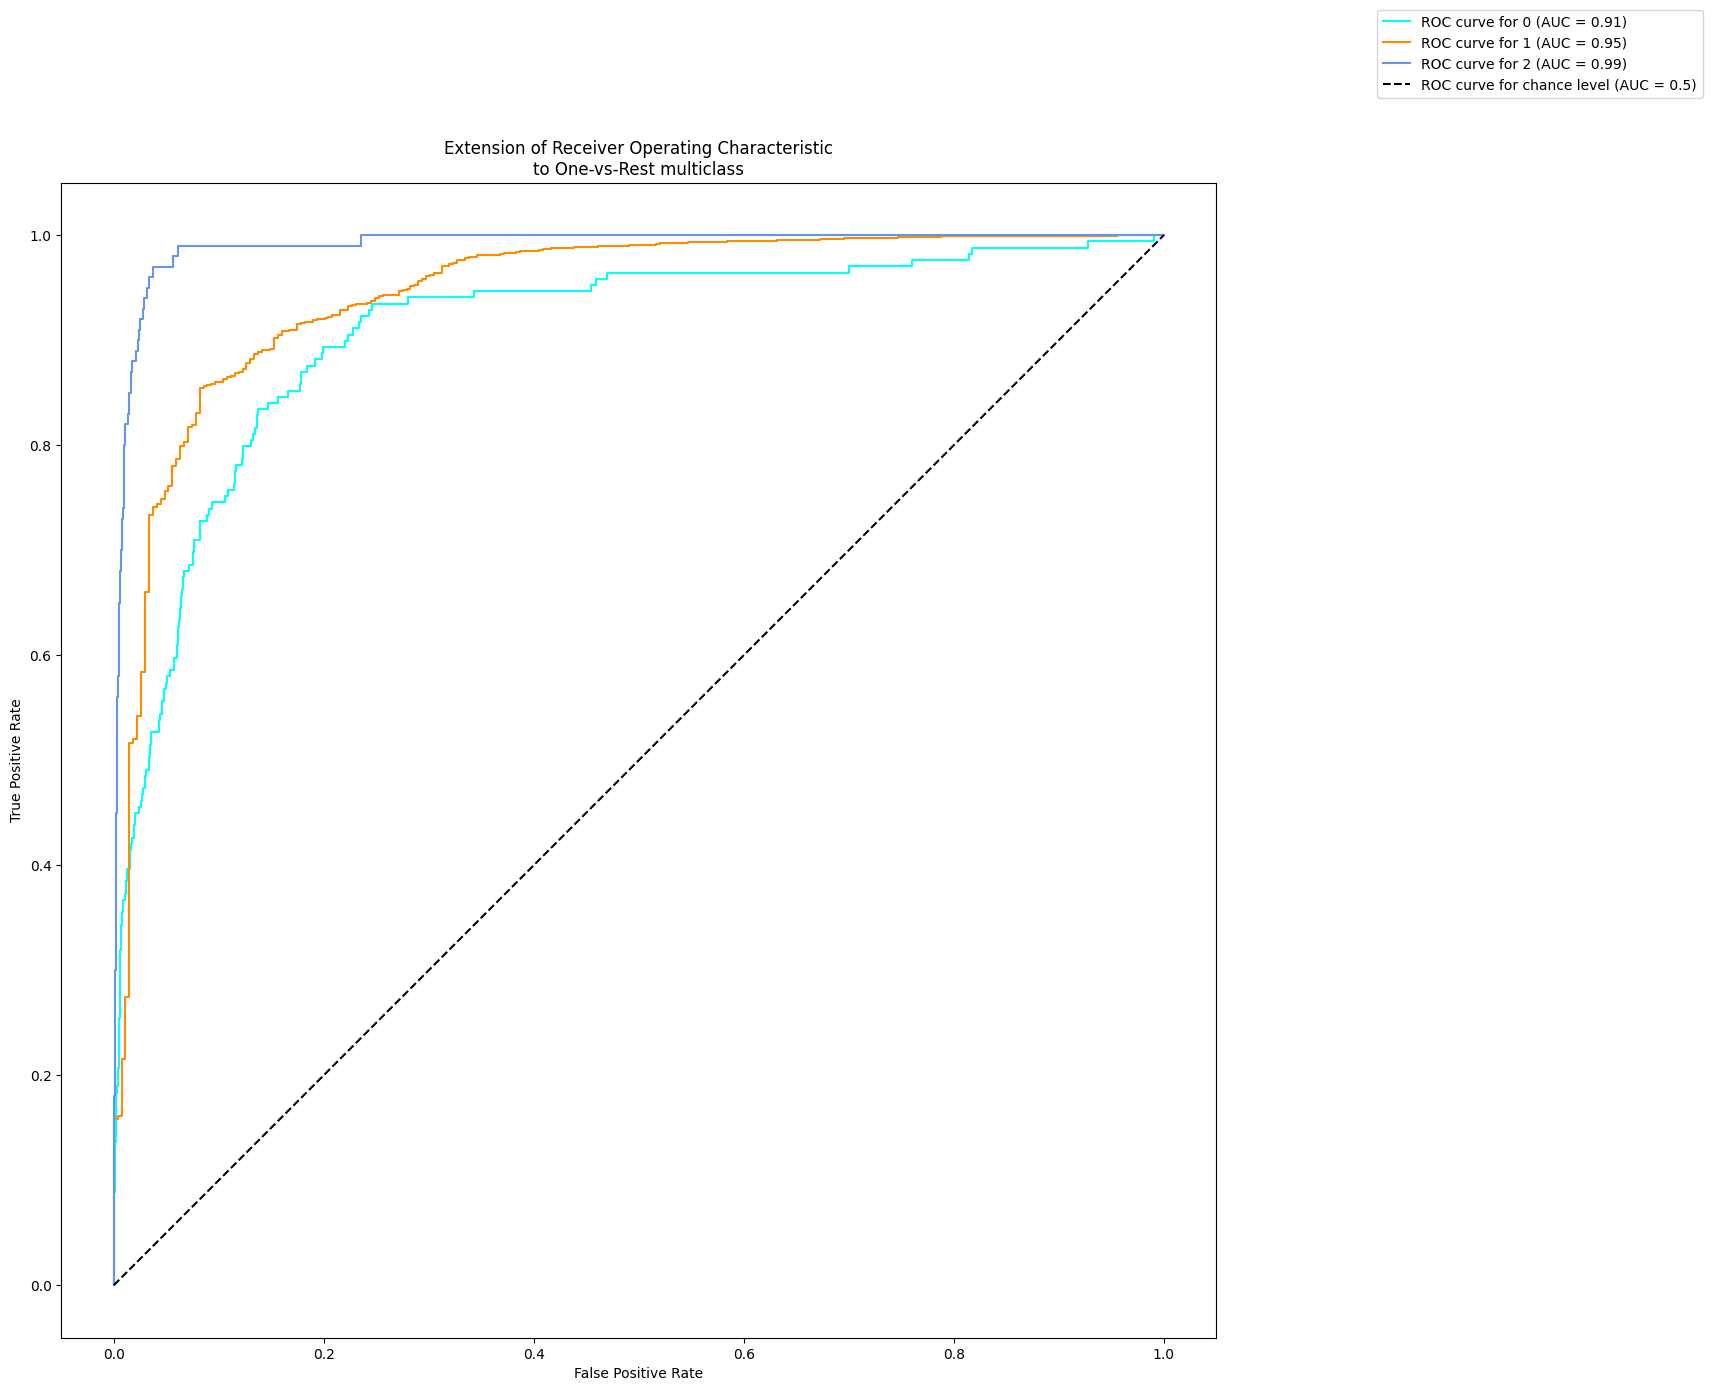

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.31      0.57      0.41       169
           1       0.98      0.94      0.96      3879
           2       0.61      0.79      0.69       100

    accuracy                           0.92      4148
   macro avg       0.64      0.77      0.68      4148
weighted avg       0.95      0.92      0.93      4148

##################################################  Saliency Maps  ##################################################

Class 0:


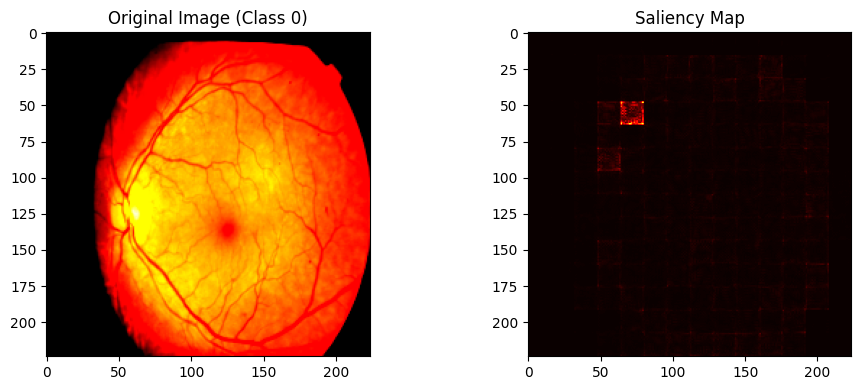

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


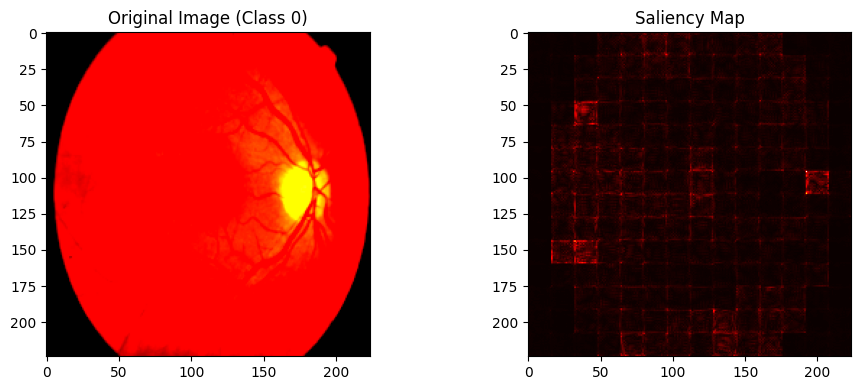

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


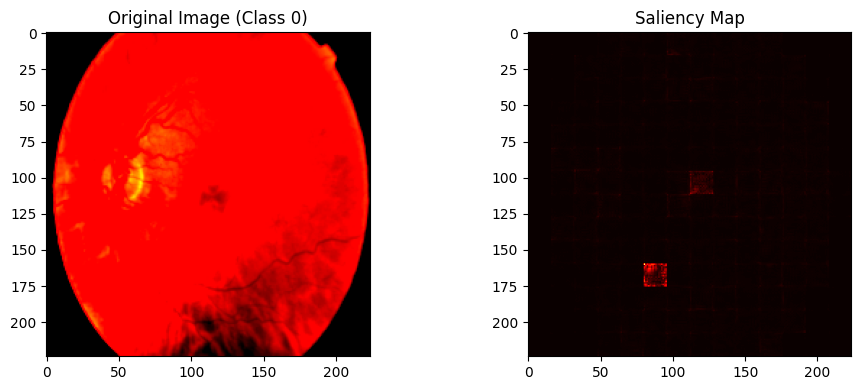

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


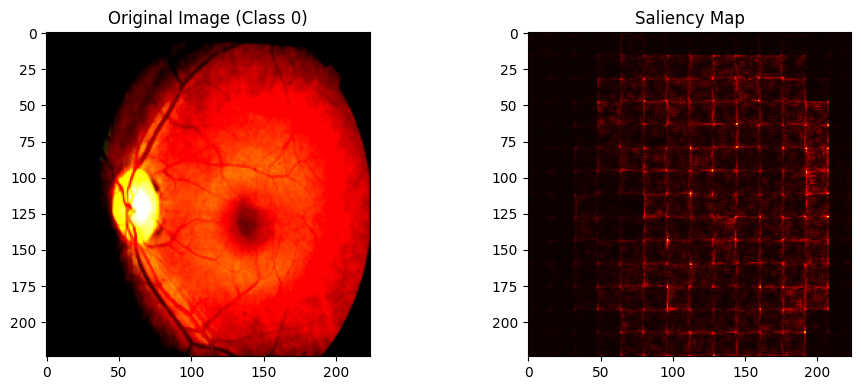

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


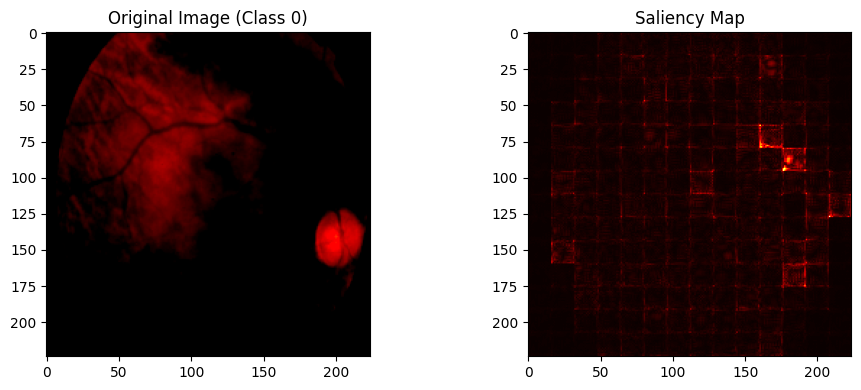

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


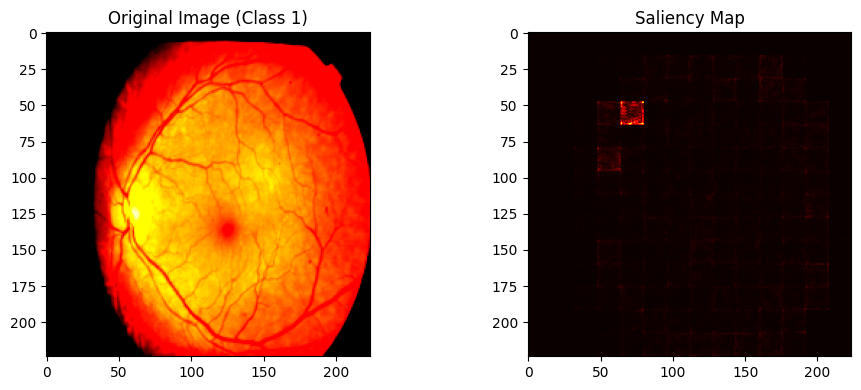

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


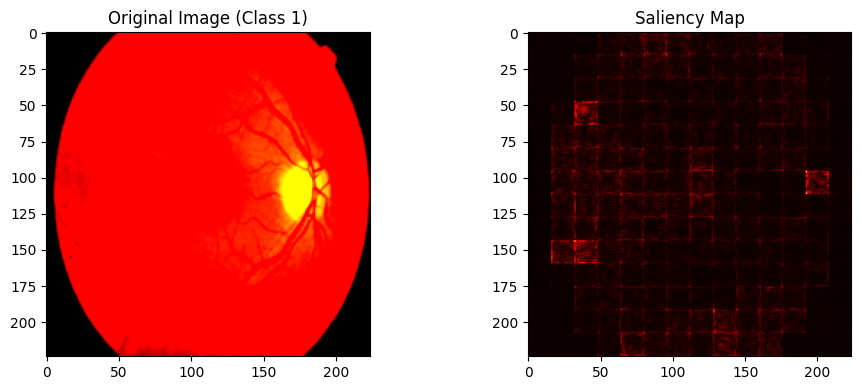

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


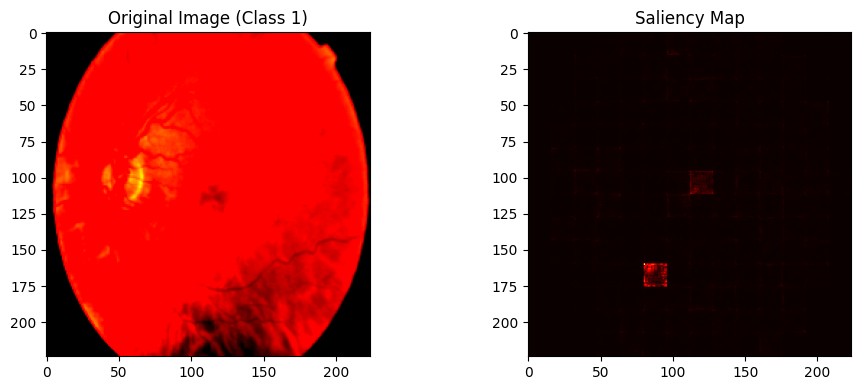

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


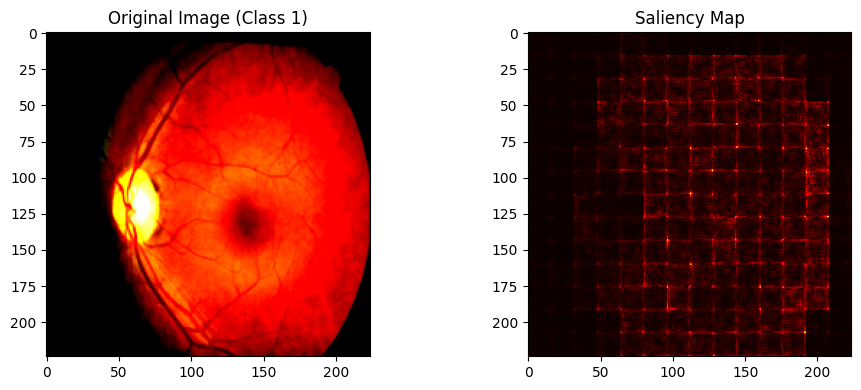

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


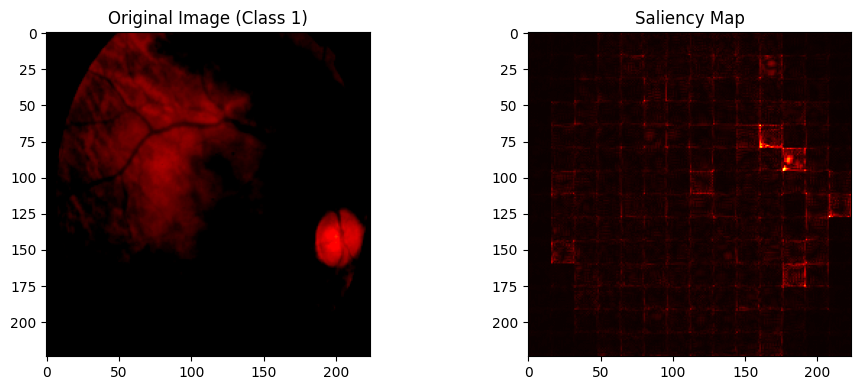

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


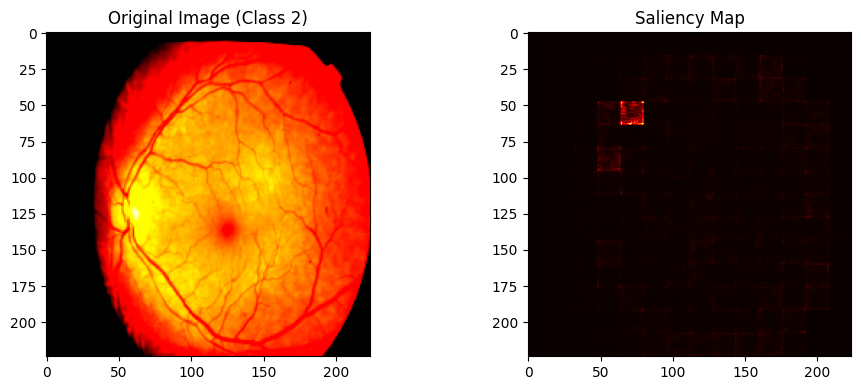

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


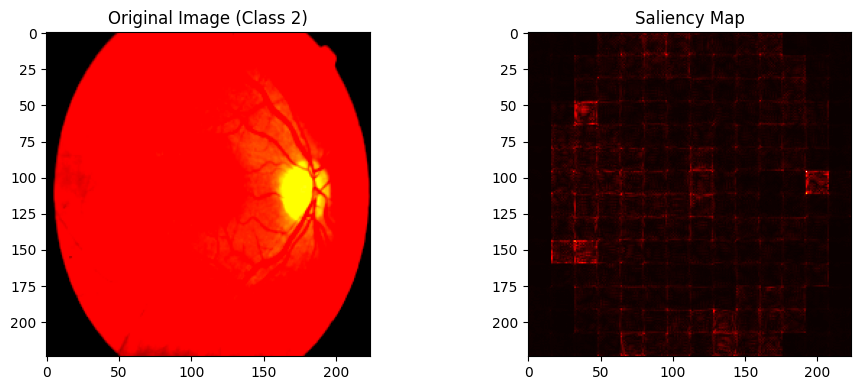

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


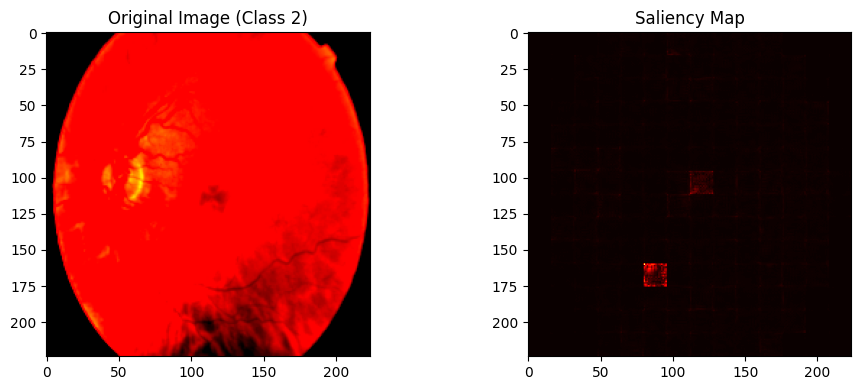

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


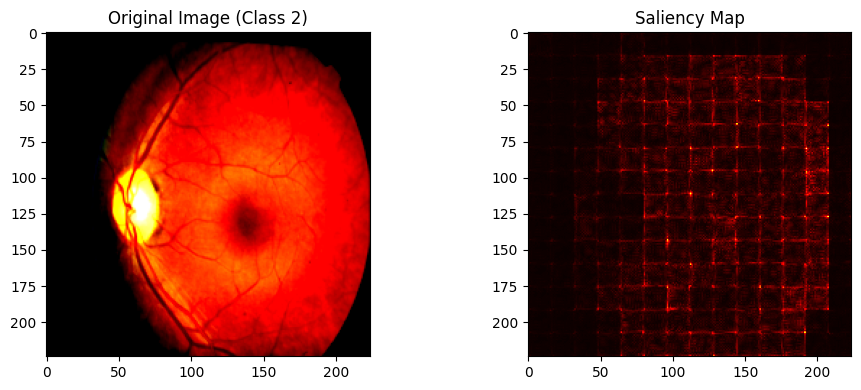

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


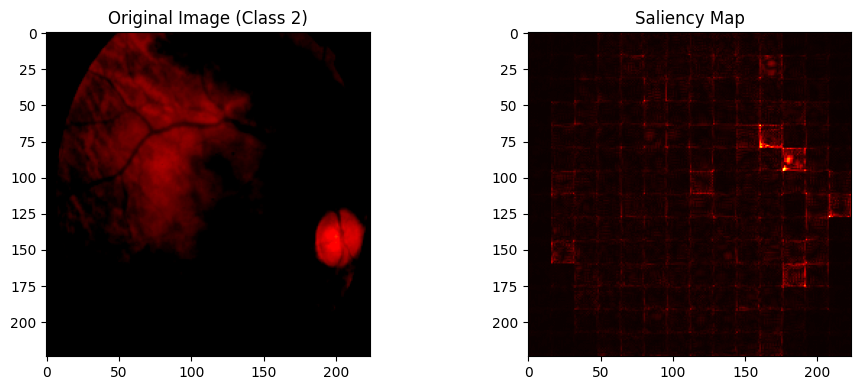

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 455/455 [02:06<00:00,  3.59it/s]


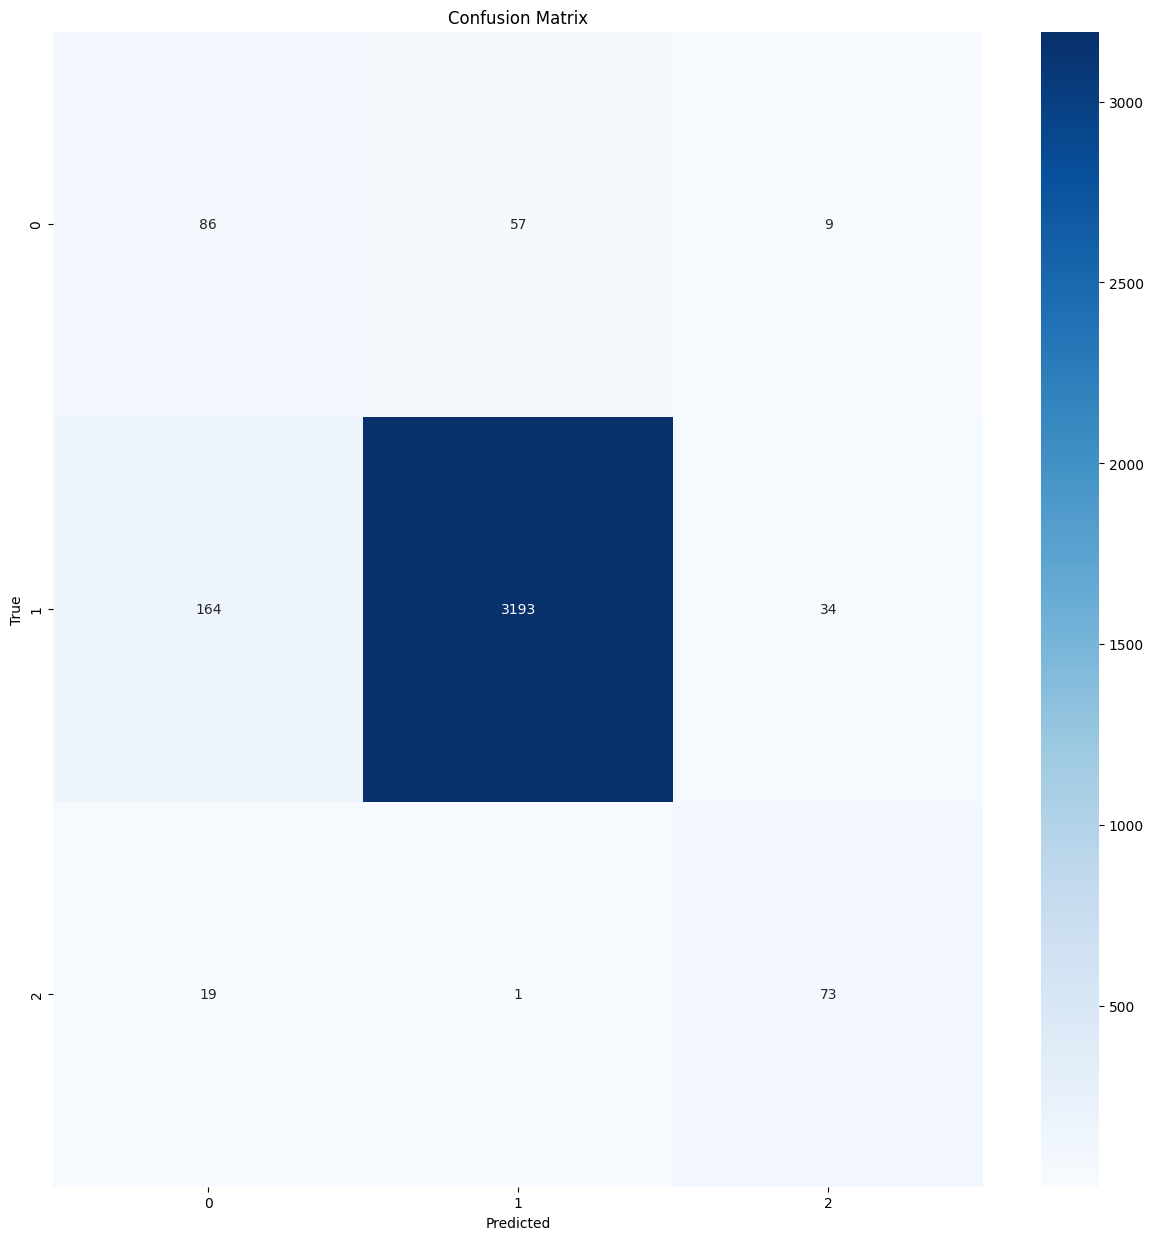

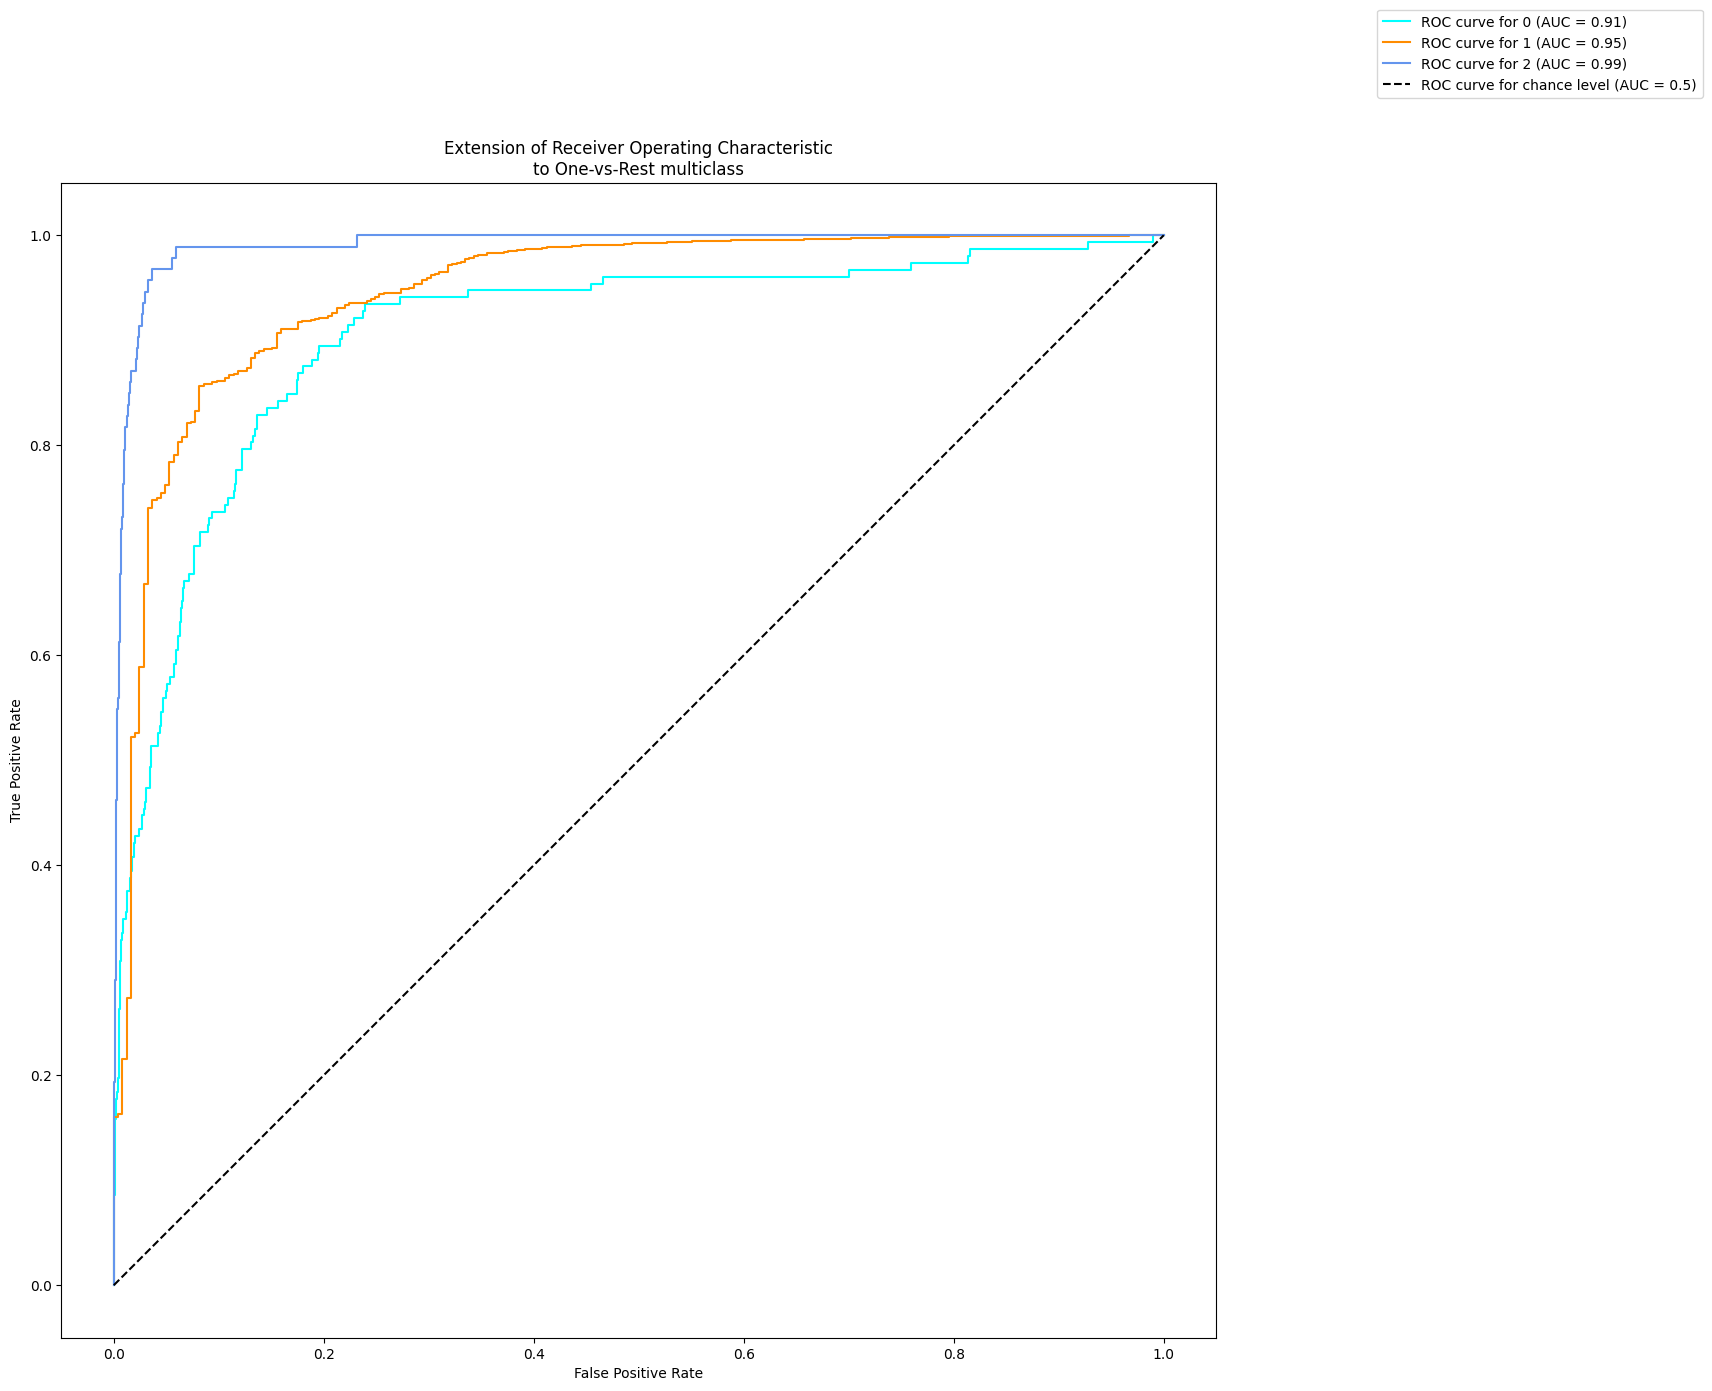

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.32      0.57      0.41       152
           1       0.98      0.94      0.96      3391
           2       0.63      0.78      0.70        93

    accuracy                           0.92      3636
   macro avg       0.64      0.76      0.69      3636
weighted avg       0.95      0.92      0.93      3636

##################################################  Saliency Maps  ##################################################

Class 0:


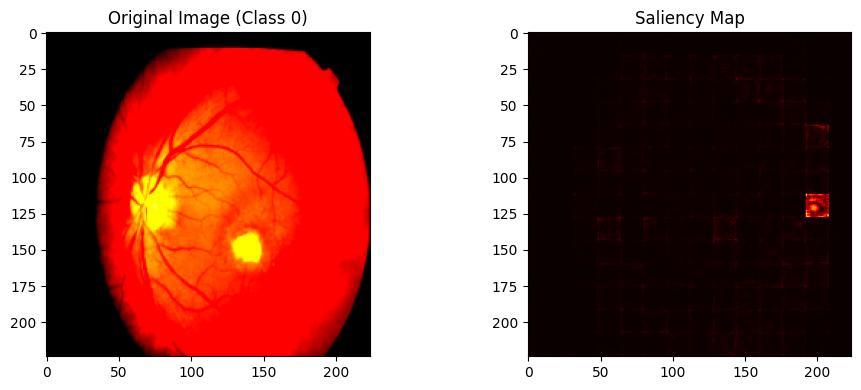

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


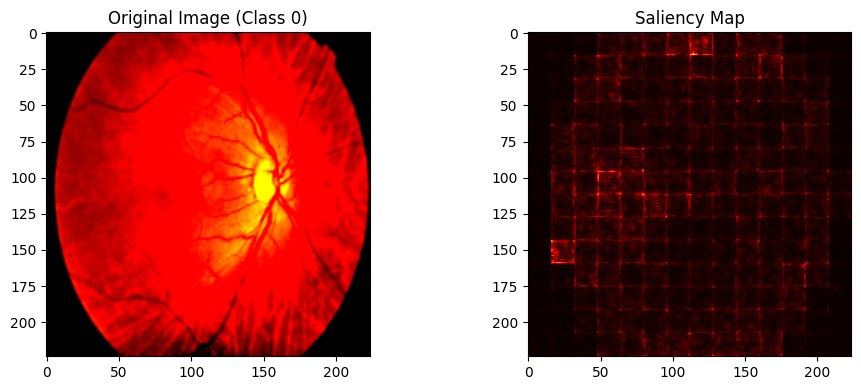

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


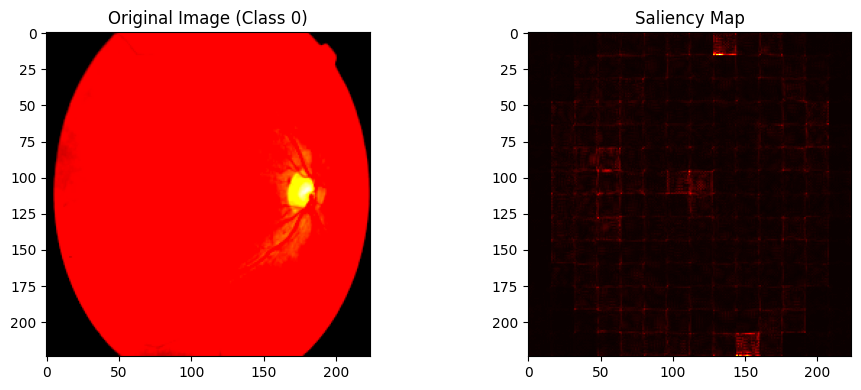

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


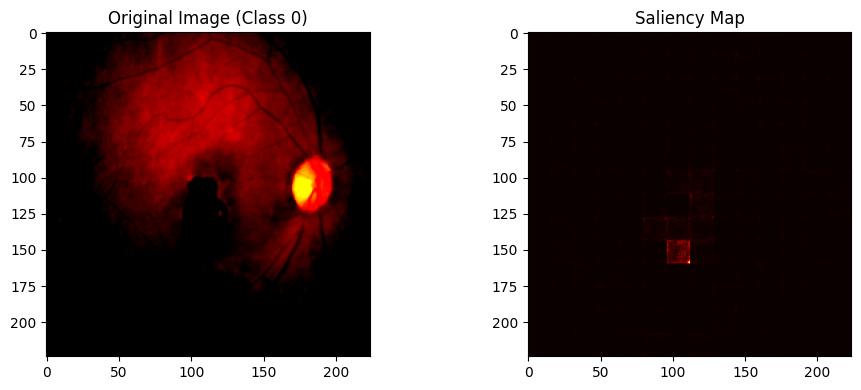

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


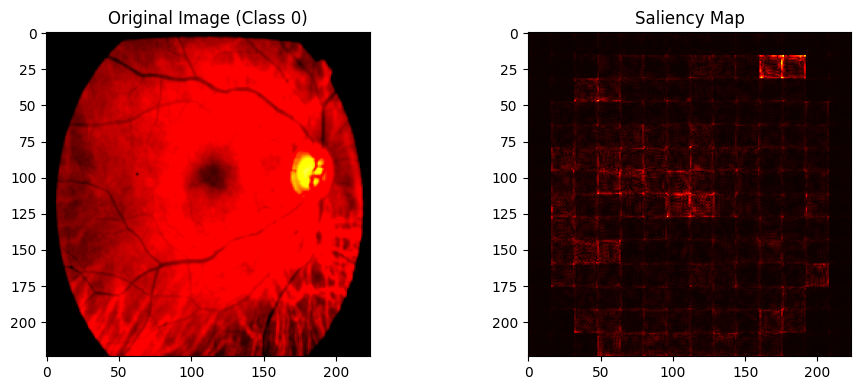

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


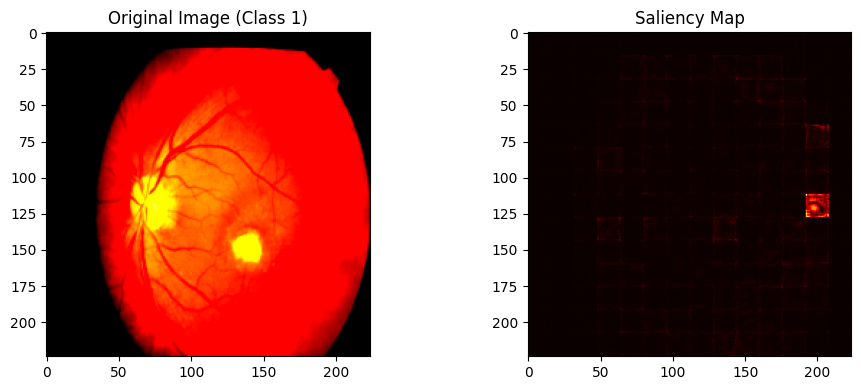

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


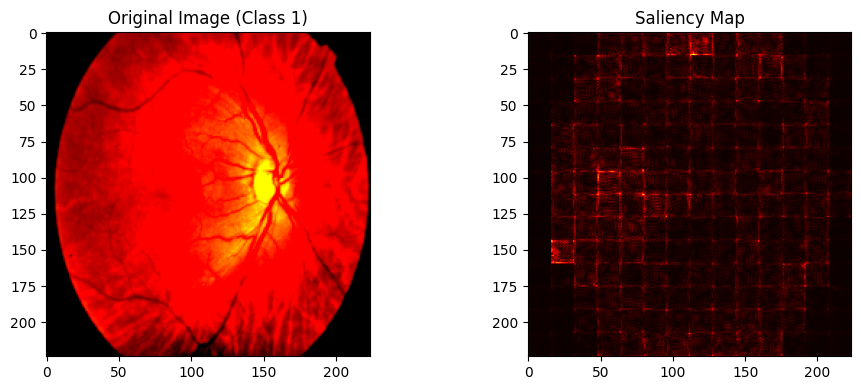

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


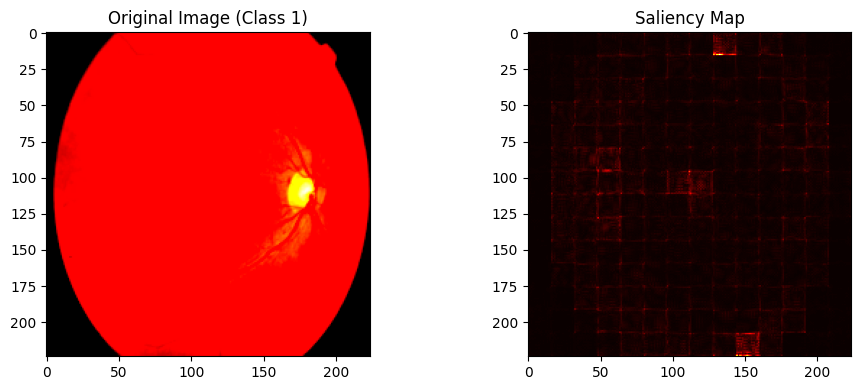

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


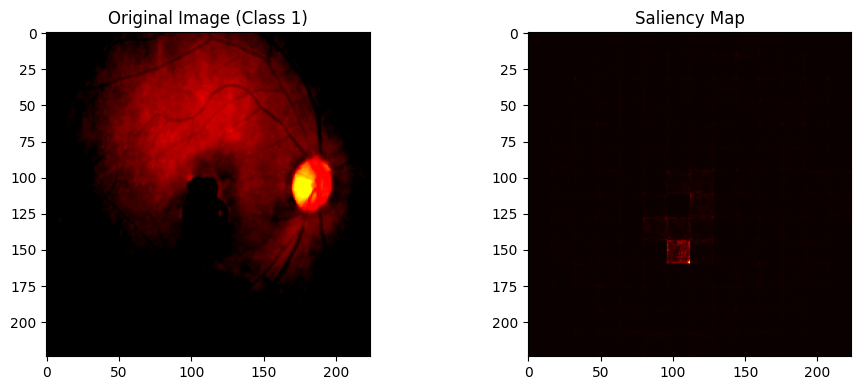

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


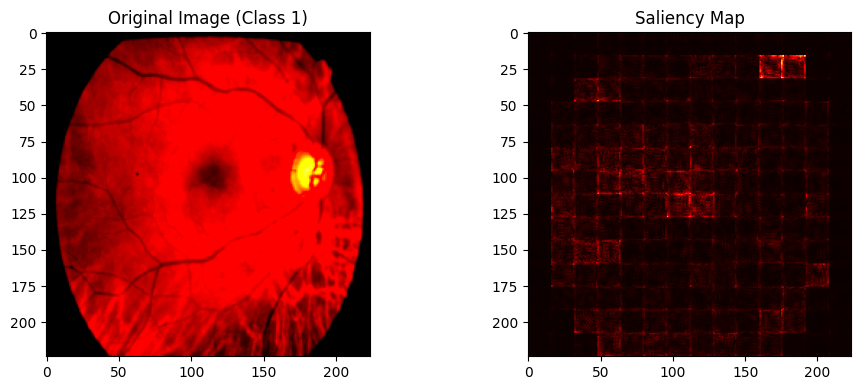

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


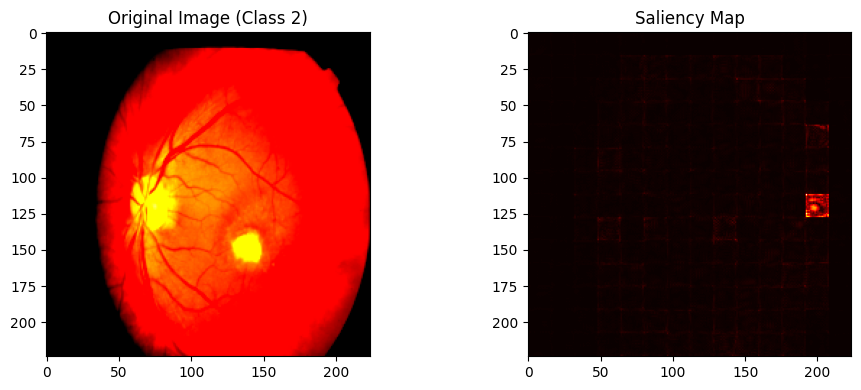

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


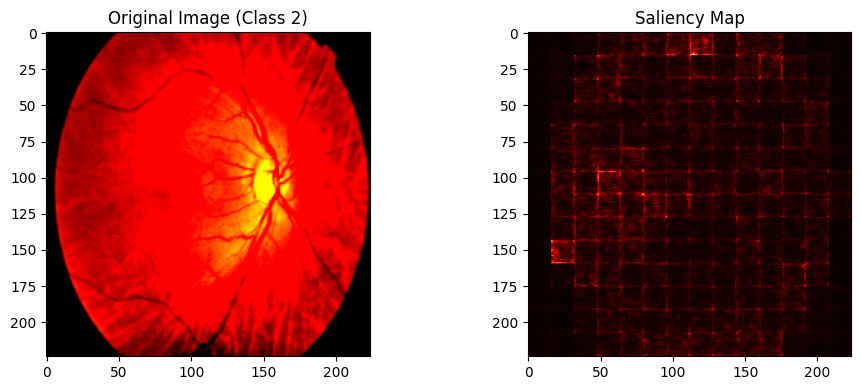

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


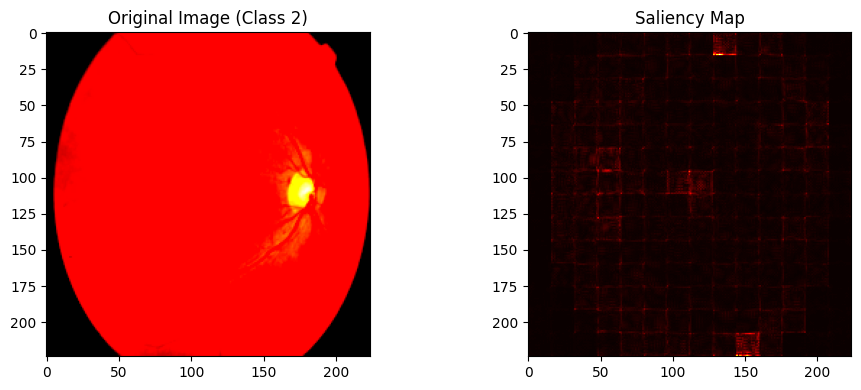

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


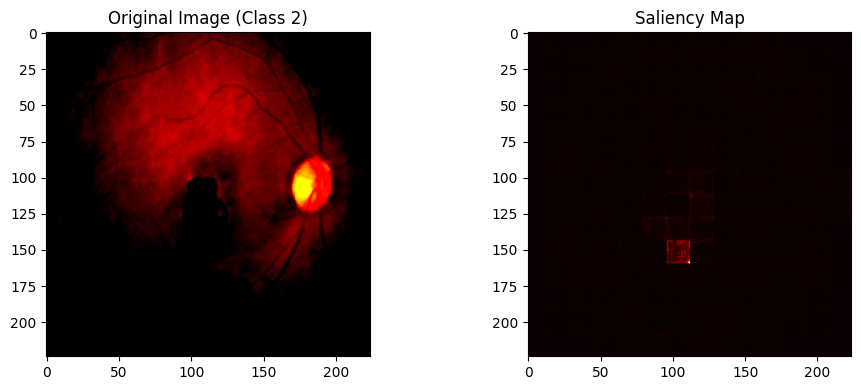

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


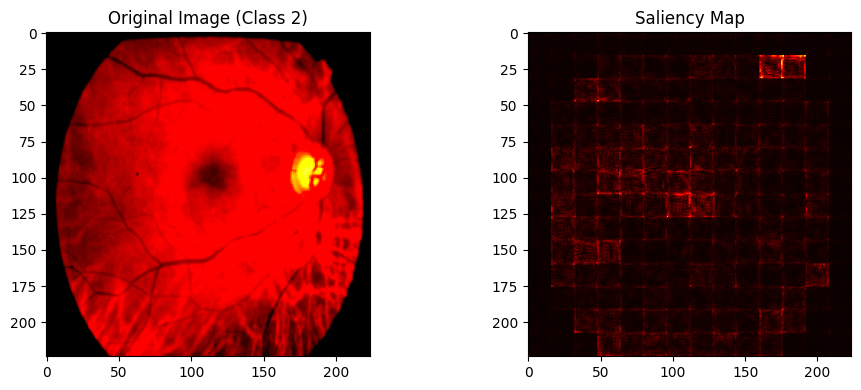

In [15]:
test(model, adequate_dataloader, saliency=True, device=device)

#### Inadequate image quality

100%|██████████| 64/64 [00:18<00:00,  3.38it/s]


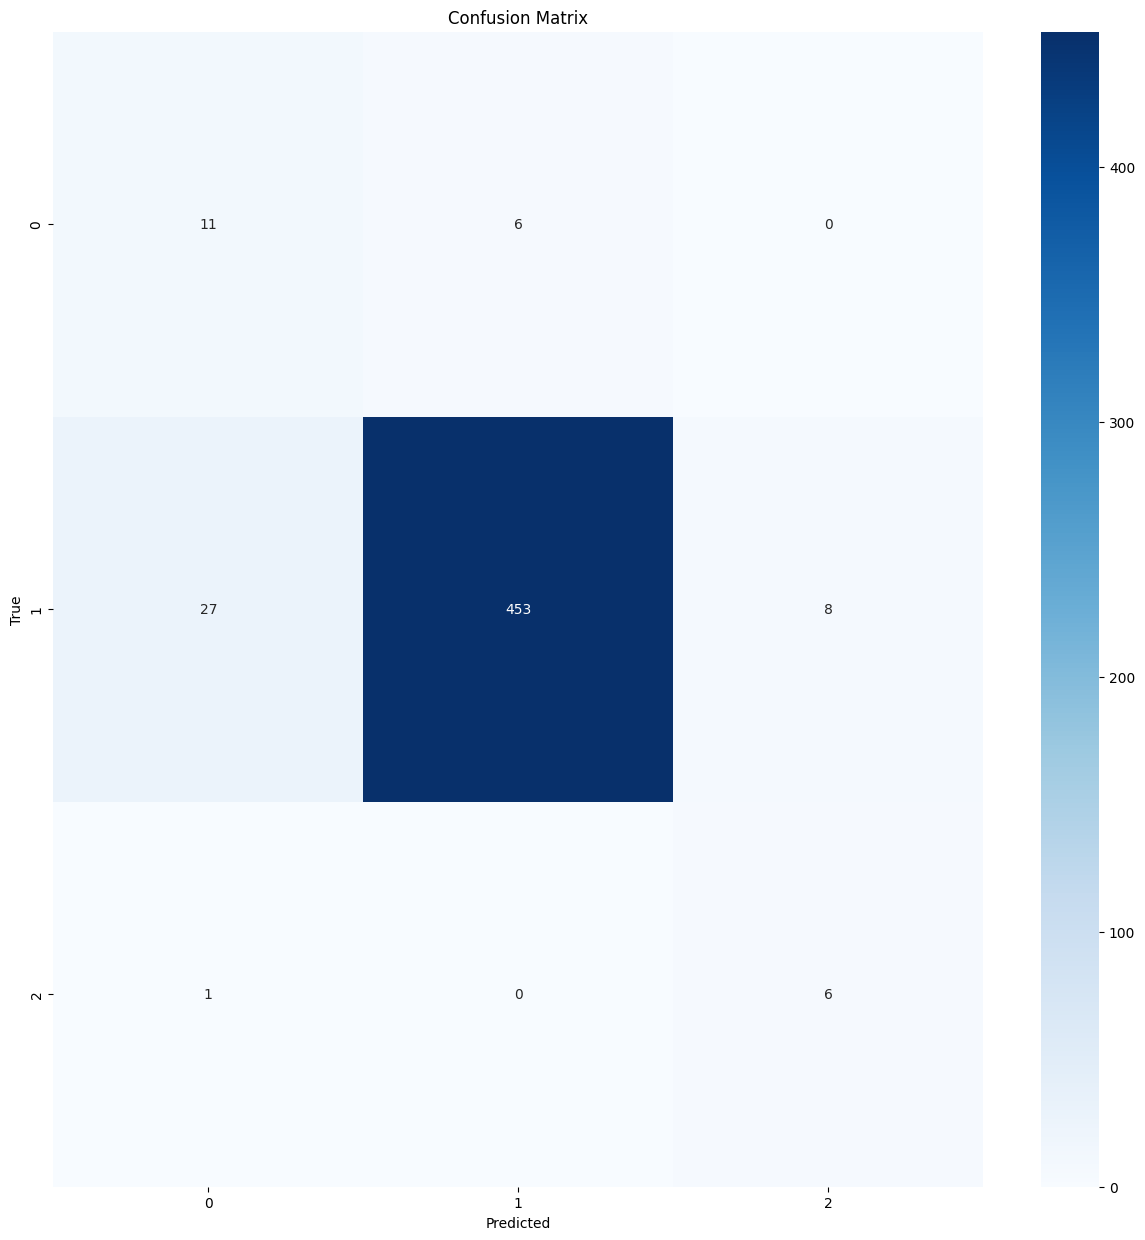

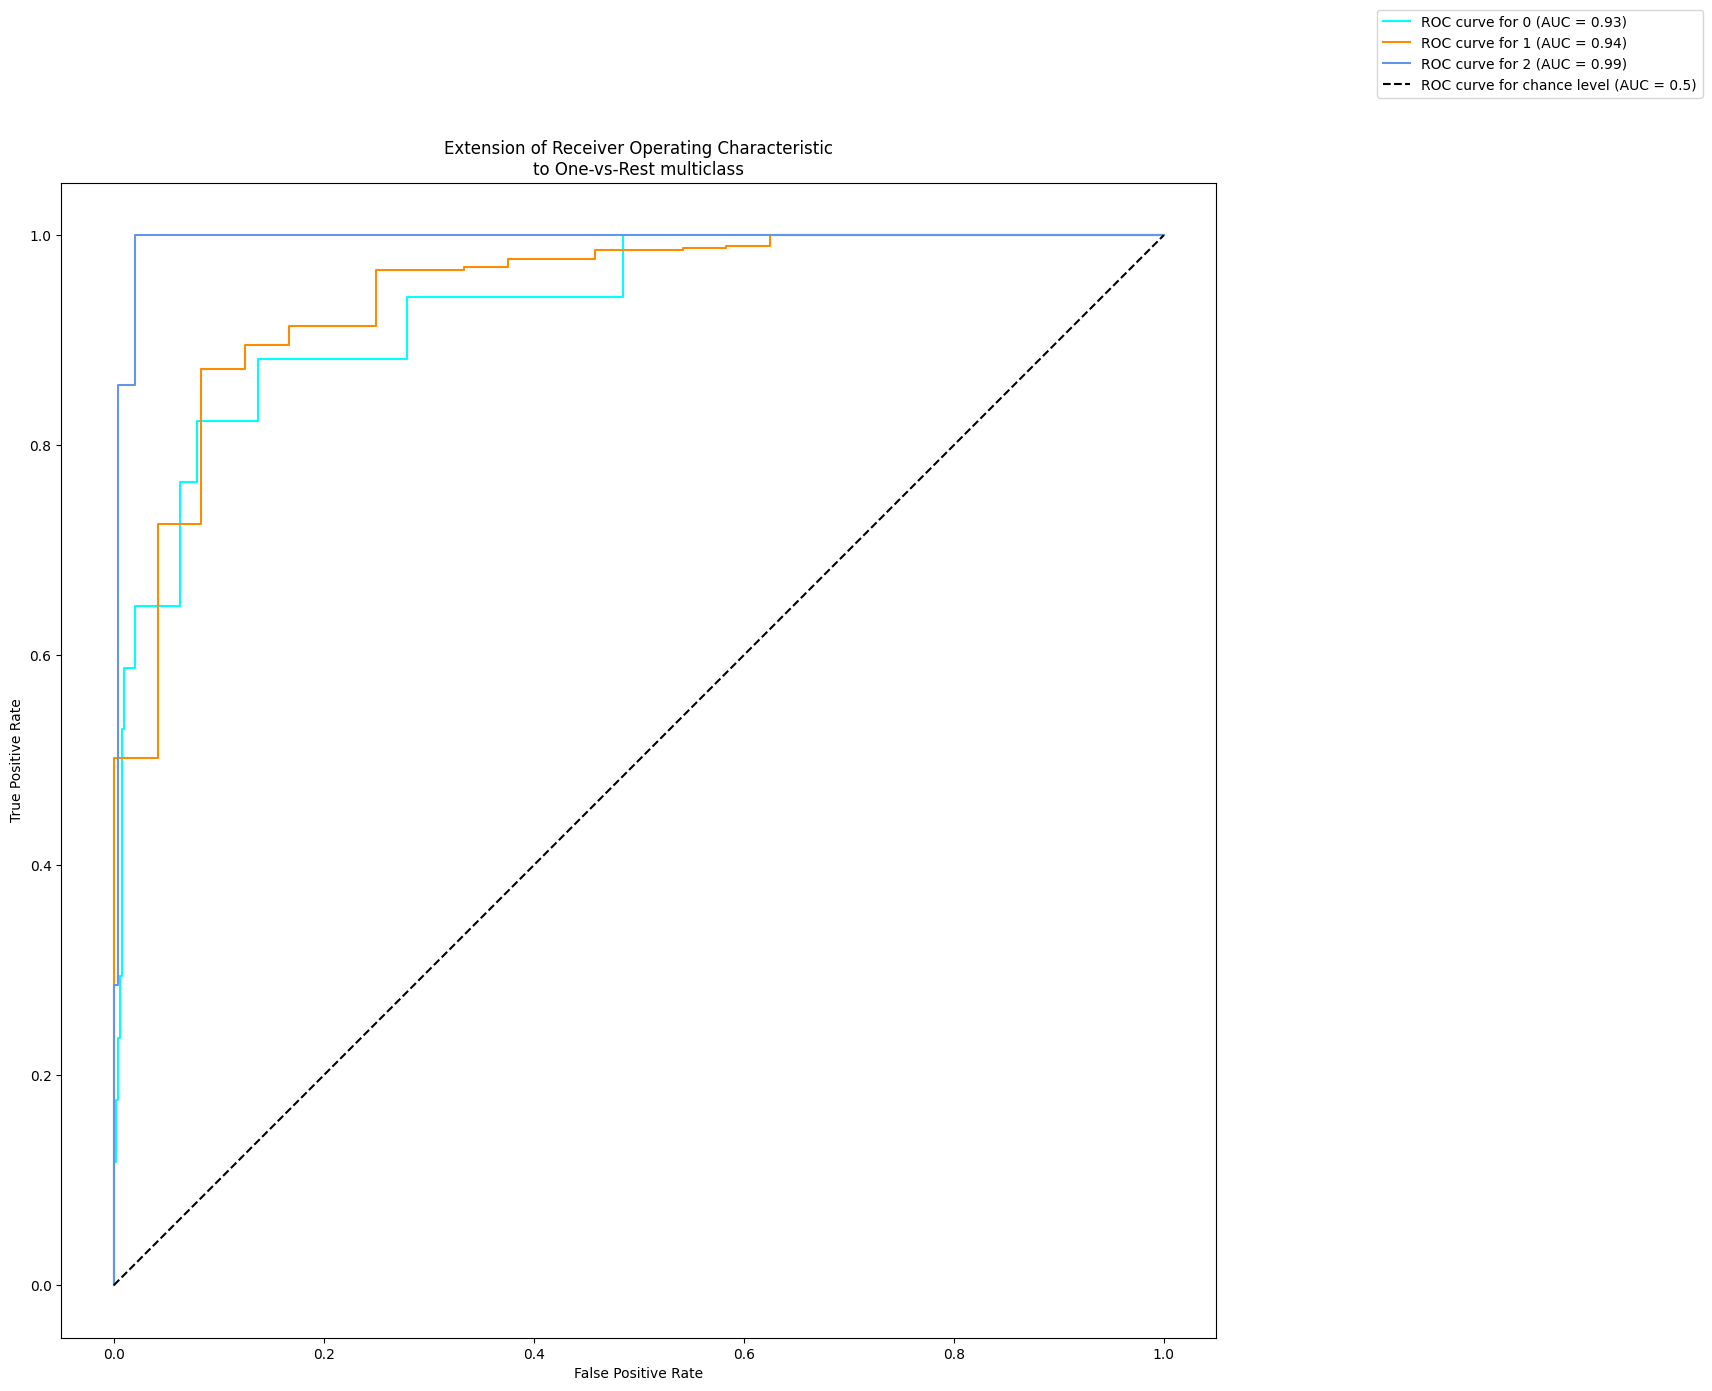

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.28      0.65      0.39        17
           1       0.99      0.93      0.96       488
           2       0.43      0.86      0.57         7

    accuracy                           0.92       512
   macro avg       0.57      0.81      0.64       512
weighted avg       0.96      0.92      0.93       512

##################################################  Saliency Maps  ##################################################

Class 0:


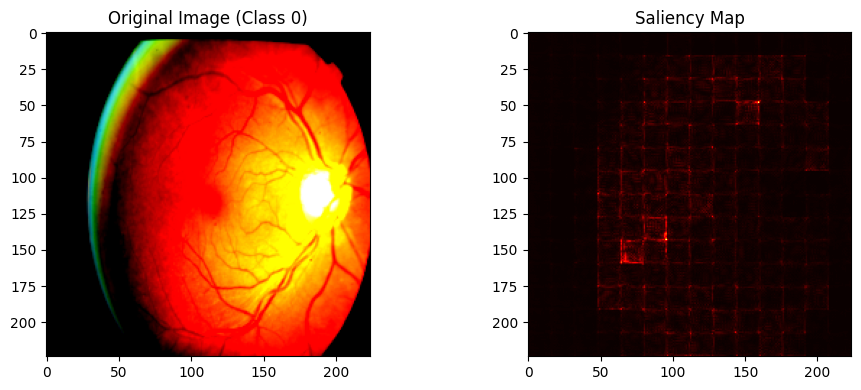

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


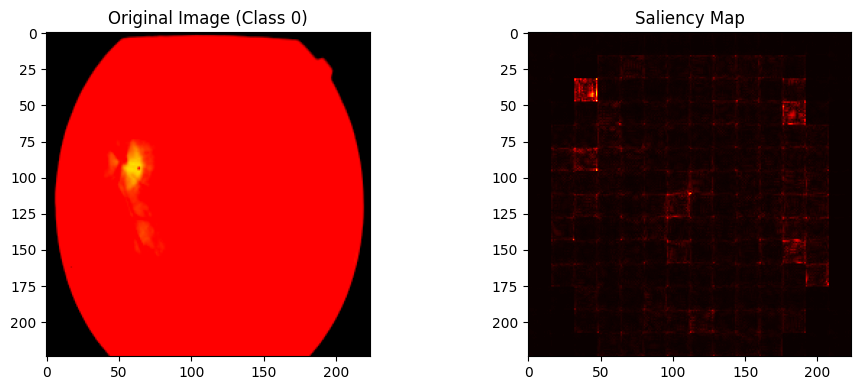

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


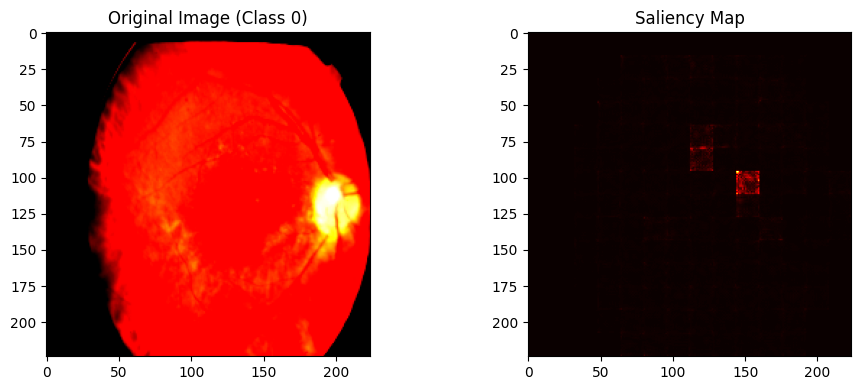

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


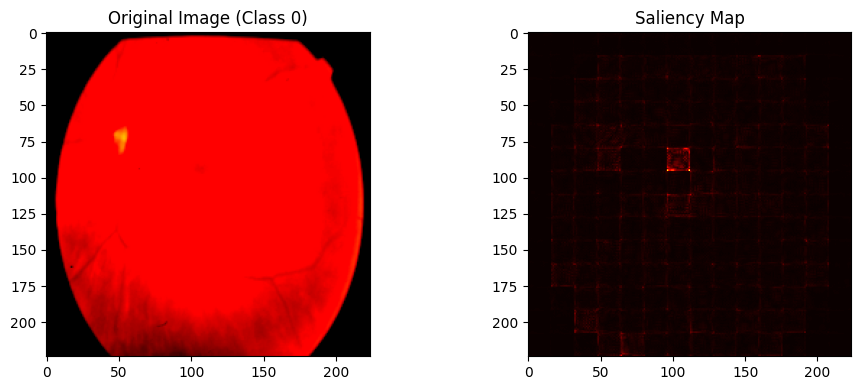

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


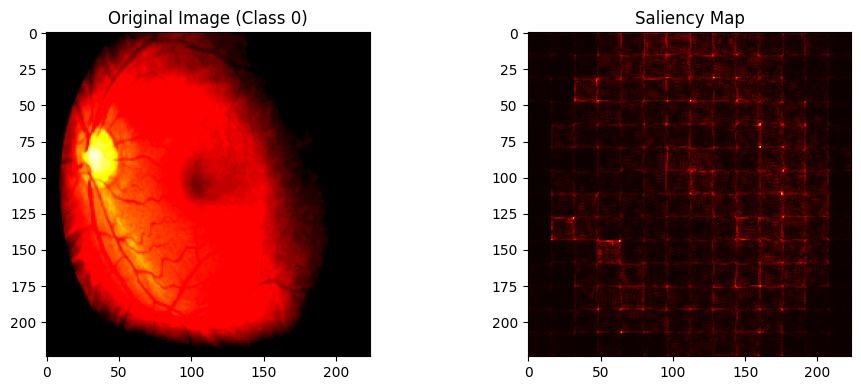

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


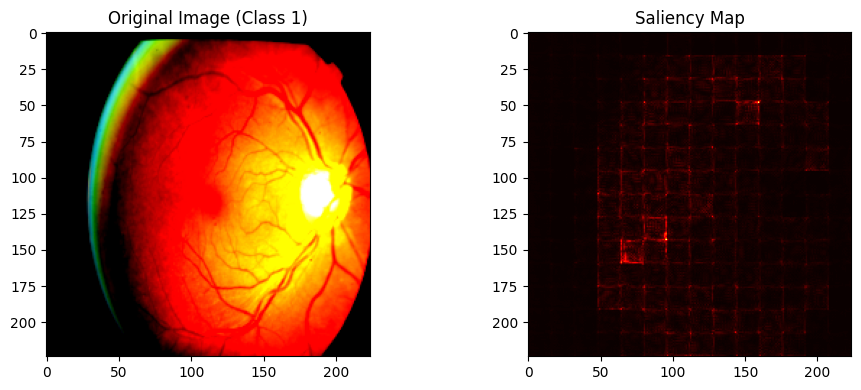

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


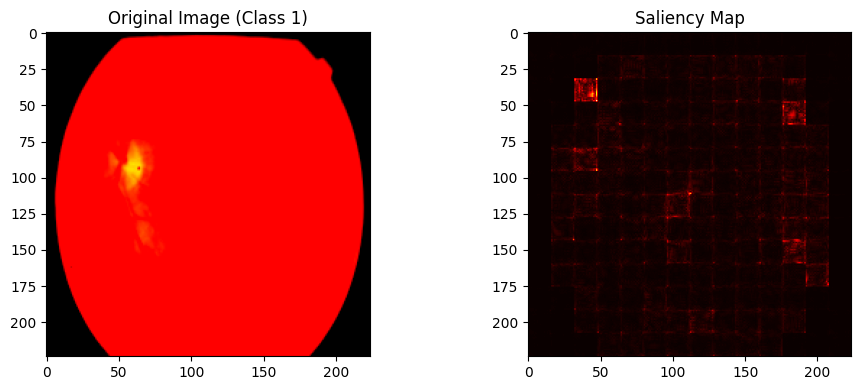

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


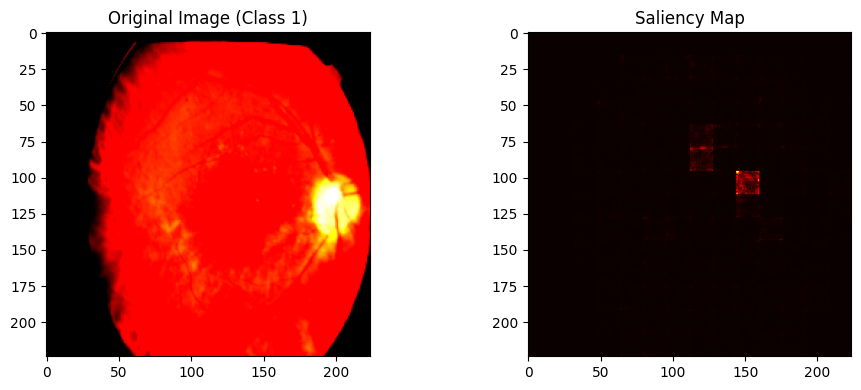

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


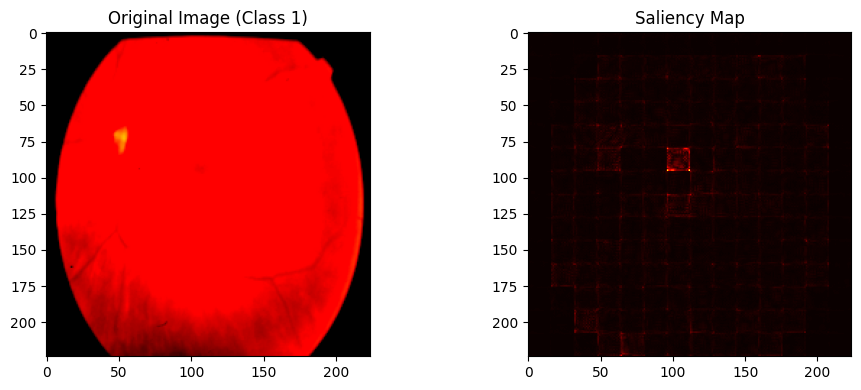

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


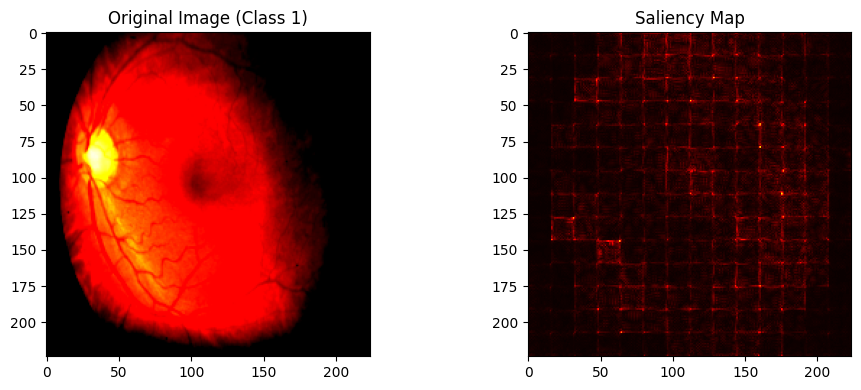

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 2:


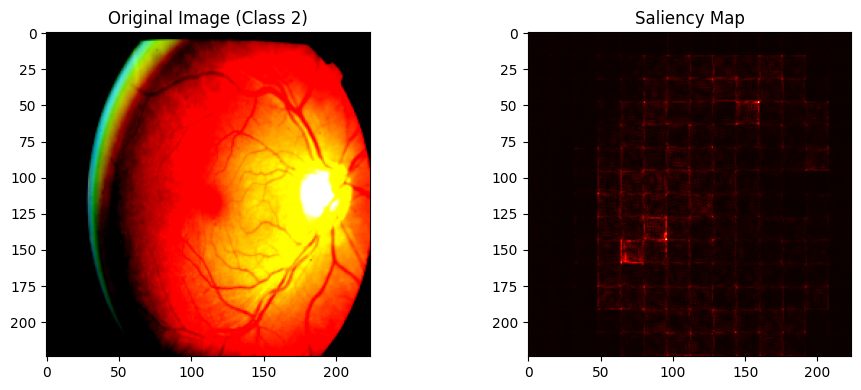

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


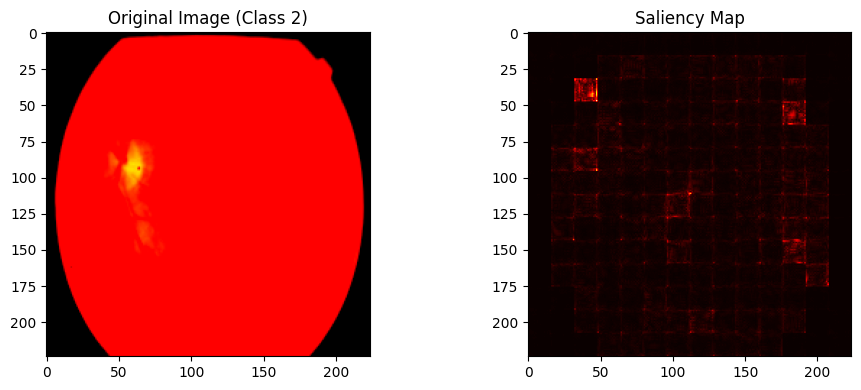

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


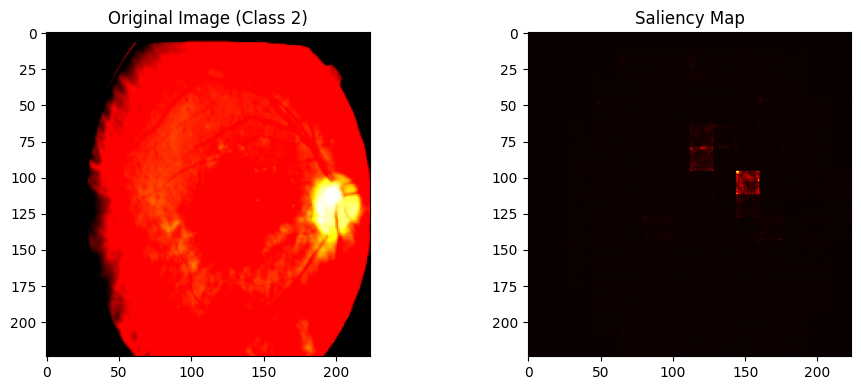

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


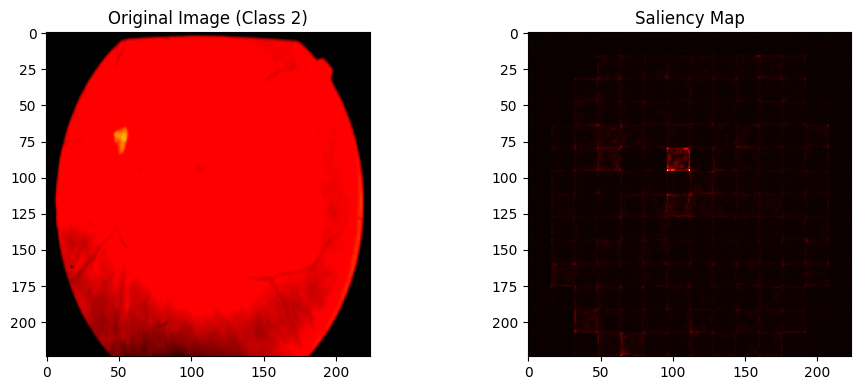

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


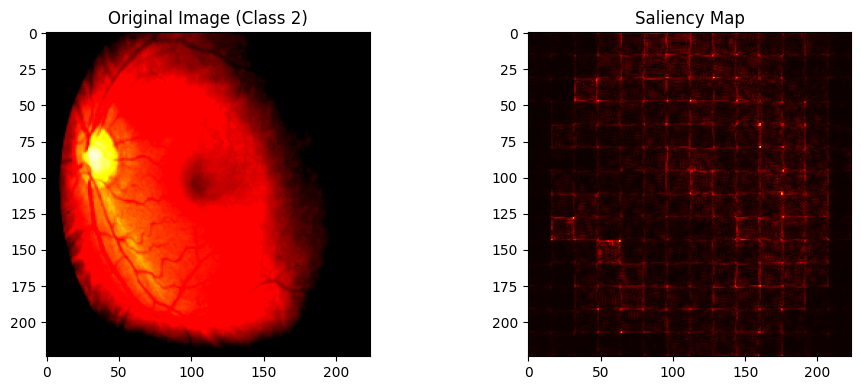

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)